<img src="https://i1.sndcdn.com/avatars-000274765548-vj7h0w-t500x500.jpg" style='float:right; width:200px; margin: 0 20px;'>

<img src="https://cdn2.iconfinder.com/data/icons/popular-social-media-flat/48/Popular_Social_Media-11-512.png" style='float:right; width:200px; margin: 0 20px;'>


# Twitter V CMV topological differences --> Twitter
---

> Create feature set for CMV and Twitter 

> Do comperative analysis of features

In [1]:
# env 
import sys
sys.path.append('/Users/shaimeital/code/thesis/conversant')
sys.path.append('/Users/shaimeital/code/thesis/cmv-stance-classification')


In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import glob
import os
from tqdm.notebook import tqdm

import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [3]:
from conversant.conversation.examples.controversial_feature_extraction import *
from conversant.conversation\
    .conversation_utils import conversation_to_dataframe
from stance_classification.twitter_conversation_parser import TwitterConversationReader

from stance_classification.classifiers.maxcut_stance_classifier import MaxcutStanceClassifier

ImportError: DLL load failed: The specified module could not be found.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

## Load Raw Data

In [3]:
twitter_conversations_path = r"C:\Users\ronp\Documents\stance-classification\rumors_dataset\PHEME_veracity\full-conversations"
# twitter_conversations_path = "/Users/shaimeital/code/thesis/cmv-stance-classification/data/Twitter Conversation/rumers/full-conversations"
twitter_conversation_ids = [file for file in os.listdir(twitter_conversations_path)]

NameError: name 'os' is not defined

In [ ]:
# one example
conv_id = "498235547685756928"
conversation_path = os.path.join(twitter_conversations_path, conv_id, "tweets.jsonl")
sample = pd.read_json(conversation_path,
                     lines= True,
                     dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'full_text':str, 'id_str':str})
sample

In [ ]:
twitter_conversations = []
error = 0
for conv_id in tqdm(twitter_conversation_ids):
    conversation_path = os.path.join(twitter_conversations_path, conv_id, "tweets.jsonl")
    try:
        current= pd.read_json(conversation_path,
                         lines= True,
                         dtype={'in_reply_to_status_id_str':str, 'conversation_id_str': str, 'full_text':str, 'id_str':str})
        twitter_conversations.append(current)
    except:
        error+=1
        pass

In [11]:
error

0

## Transform to Conversation object and to feature set

In [12]:
twitter_reader = TwitterConversationReader(merge_sequential=True)

In [ ]:
conv_df = twitter_conversations[0]
conv = twitter_reader.parse(conv_df)

In [13]:
conversations = []
error = 0
for conv_ in tqdm(twitter_conversations):
    try:
        conversation = twitter_reader.parse(conv_)
        conversations.append(conversation)
    except:
        error += 1
        pass

100%|██████████| 6424/6424 [00:10<00:00, 598.77it/s]


In [14]:
error

6424

In [40]:
sub_convs = (Conversation(child) for conv in conversations for child in conv.root.children)
#sub_convs = filter(lambda c: c.size >= 5, sub_convs)
#features = map(get_features, sub_convs)

In [42]:
#data_with_root = pd.concat(conversation_to_dataframe(conv) for conv in sub_convs)

In [45]:
convs = pd.concat(conversation_to_dataframe(conv) for conv in conversations) 

In [46]:
convs.head()

,author,parent_id,depth,is_root,is_absolute_root,is_leaf,timestamp,conversation_id,full_conv_id,data.created_at,...,data.card.users.17659340.profile_banner_extensions_media_color.palette,data.card.users.17659340.profile_link_color,data.card.users.17659340.pinned_tweet_ids,data.card.users.17659340.pinned_tweet_ids_str,data.card.users.17659340.has_custom_timelines,data.card.users.17659340.advertiser_account_type,data.card.users.17659340.advertiser_account_service_levels,data.card.users.17659340.profile_interstitial_type,data.card.users.17659340.business_profile_state,data.card.users.17659340.translator_type
node_id,,,,,,,,,,,,,,,,,,,,,
500363141034020865,27172787,None,0,True,True,False,2014-08-15 19:27:23+00:00,500363141034020865,500363141034020865,2014-08-15 19:27:23+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500402163966025729,16515767,500363141034020865,1,False,False,True,2014-08-15 22:02:27+00:00,500363141034020865,500363141034020865,2014-08-15 22:02:27+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500401882276585472,1639960820,500363141034020865,1,False,False,True,2014-08-15 22:01:20+00:00,500363141034020865,500363141034020865,2014-08-15 22:01:20+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500398670358257664,1656331460,500363141034020865,1,False,False,True,2014-08-15 21:48:34+00:00,500363141034020865,500363141034020865,2014-08-15 21:48:34+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500425964778557440,2298877380,500363141034020865,1,False,False,True,2014-08-15 23:37:02+00:00,500363141034020865,500363141034020865,2014-08-15 23:37:02+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

### Mean branch participation for user in CMV
remove op and show that most users in a conversation only participaten in one branch

In [47]:
roots = convs.loc[convs.is_root == True][['author', 'full_conv_id']]
roots

,author,full_conv_id
node_id,,
500363141034020865,27172787,500363141034020865
580320995266936832,16834659,580320995266936832
524950899899113473,21212604,524950899899113473
553529101659566080,24506246,553529101659566080
580336204186521600,2280470022,580336204186521600
...,...,...
544415816851021824,1513504760,544415816851021824
553107688591089664,622888708,553107688591089664
529666235710332928,23885575,529666235710332928


In [ ]:
def conversattion_to_dataframe_filter_root(conv):
    conv = conversation_to_dataframe(conv)
    full_conv_id = conv.full_conv_id[:1].values[0]
    root_author_name = roots.loc[roots.full_conv_id == full_conv_id].author.values[0]
    return conv.loc[conv.author != root_author_name]

In [ ]:
data = pd.concat(conversattion_to_dataframe_filter_root(conv) for conv in sub_convs) 

In [48]:
data = convs

In [49]:
user_participation=pd.DataFrame(data.groupby(['author', 'conversation_id']).timestamp.count())\
                    .rename({'timestamp': '#participation'}, axis=1)
user_participation.head()

,,#participation
author,conversation_id,
58,500396027342376960,2
59,500396027342376960,1
521,498248648699150336,1
4816,553227856046596097,1
7698,552805050620604418,1


In [50]:
mean_branch_participation = pd.DataFrame(user_participation.groupby('author')['#participation'].mean()).\
                            rename({'#participation': 'mean_branch_participation'}, axis=1)
mean_branch_participation.head()

,mean_branch_participation
author,
58,2.0
59,1.0
521,1.0
4816,1.0
7698,1.0


In [52]:
bins = [0,1,2,3,4,5,6,7,8,9,72]

In [53]:
mean_branch_participation['mean_par_bin'] = pd.cut(mean_branch_participation.mean_branch_participation, bins=bins)

In [54]:
mean_branch_participation

,mean_branch_participation,mean_par_bin
author,,
58,2.0,"(1.0, 2.0]"
59,1.0,"(0.0, 1.0]"
521,1.0,"(0.0, 1.0]"
4816,1.0,"(0.0, 1.0]"
7698,1.0,"(0.0, 1.0]"
...,...,...
987413828,1.0,"(0.0, 1.0]"
987445464,1.0,"(0.0, 1.0]"
99336446,1.0,"(0.0, 1.0]"


In [55]:
mean_branch_participation.describe()

,mean_branch_participation
count,31106.000000
mean,1.191659
std,1.659239
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,132.000000


In [56]:
bin_participation = mean_branch_participation.groupby('mean_par_bin').count()
bin_participation

,mean_branch_participation
mean_par_bin,
"(0, 1]",27038
"(1, 2]",2249
"(2, 3]",514
"(3, 4]",199
"(4, 5]",117
"(5, 6]",59
"(6, 7]",38
"(7, 8]",26
"(8, 9]",24


In [57]:
bin_participation = bin_participation.reset_index()
bin_participation

,mean_par_bin,mean_branch_participation
0,"(0, 1]",27038
1,"(1, 2]",2249
2,"(2, 3]",514
3,"(3, 4]",199
4,"(4, 5]",117
5,"(5, 6]",59
6,"(6, 7]",38
7,"(7, 8]",26
8,"(8, 9]",24
9,"(9, 72]",91


In [58]:
bin_participation.mean_branch_participation.sum()

30355

In [59]:
percen = bin_participation.mean_branch_participation.apply(lambda x: x / 37264)

In [60]:
bin_participation = bin_participation.assign(perc = percen)
bin_participation

,mean_par_bin,mean_branch_participation,perc
0,"(0, 1]",27038,0.725580
1,"(1, 2]",2249,0.060353
2,"(2, 3]",514,0.013793
3,"(3, 4]",199,0.005340
4,"(4, 5]",117,0.003140
5,"(5, 6]",59,0.001583
6,"(6, 7]",38,0.001020
7,"(7, 8]",26,0.000698
8,"(8, 9]",24,0.000644
9,"(9, 72]",91,0.002442


Text(0.5, 0, 'mean participation bin')

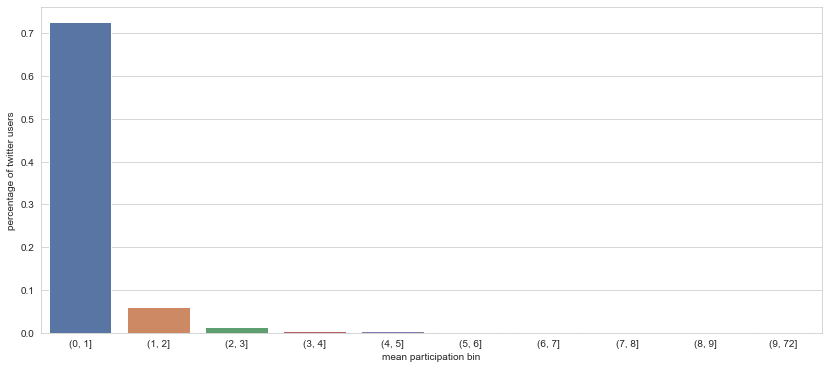

In [62]:
_, ax = plt.subplots(figsize=(14,6))
sns.set_style("whitegrid")
ax = sns.barplot(data=bin_participation, x = 'mean_par_bin', y= 'perc', palette="deep")
plt.ylabel('percentage of twitter users')
plt.xlabel('mean participation bin')

## Some Feature Extraction

In [ ]:
# example of one branch 
conv = data.loc[data.conversation_id == 'dq95b41']
conv

In [63]:
def count_op_involvment(subconv:pd.DataFrame, roots:pd.DataFrame) -> float:
    """
    counts the proportion of posts from the full conversation author in the subconversation
    """
    full_conversation_id = subconv.sample(1).full_conv_id.values[0]
    op = roots.loc[roots.full_conv_id == full_conversation_id].author.values[0]
    return len(subconv.loc[subconv.author == op]) / len(subconv)

In [ ]:
count_op_involvment(conv, roots)

In [64]:
# max branch depth 
def max_branch_depth(conv:pd.DataFrame) -> int:
    return conv.depth.max()

In [ ]:
max_branch_depth(conv)

In [65]:
# apply two features to all of the sub-conversations 
op_involvment = data.groupby('conversation_id').apply(lambda x: count_op_involvment(x, roots))

In [66]:
op_involvment.value_counts()

1.000000    510
0.500000    327
0.333333    319
0.250000    279
0.200000    270
           ... 
0.032609      1
0.158537      1
0.157895      1
0.121212      1
0.007194      1
Length: 182, dtype: int64

In [67]:
op_involvment_ = pd.DataFrame(op_involvment).rename({0:'op_involvment'}, axis=1)
op_involvment_

,op_involvment
conversation_id,
498235547685756928,0.250000
498248415223246848,0.043478
498248648699150336,0.015152
498250100079341568,0.250000
498251940997136384,0.125000
...,...
581387966125248512,0.200000
581394092648710144,0.090909
581411131547320321,0.100000


In [150]:
feature_set = data.merge(op_involvment_, how='left', on = 'conversation_id')

## Running MAXCUT

In [145]:
rumers_author_stance = []
for conversation in conversations:
    reply_interactions_parser = get_reply_interactions_parser()
    interaction_graph = reply_interactions_parser.parse(conversation)
    interaction_graph.get_core_interactions(inplace=True)
    interaction_graph.set_interaction_weights(lambda x: x['replies'])
    maxcut = MaxcutStanceClassifier()
    maxcut.set_input(interaction_graph.graph)
    op = conversation.root.author
    maxcut.classify_stance(op)
    for supporter in maxcut.supporters:
        row = {'conversation_id': conversation.id,
               'op': conversation.op,
               'author': supporter,
               'stance': 'supporter'}
        rumers_author_stance.append(row)
    for opposer in maxcut.complement:
        row = {'conversation_id': conversation.id,
               'op': conversation.op,
               'author': supporter,
               'stance': 'opposer'}
        rumers_author_stance.append(row)

In [146]:
len(rumers_author_stance)

1685

In [148]:
user_stance_rumors = pd.DataFrame(rumers_author_stance)
user_stance_rumors

,conversation_id,op,author,stance
0,553589970775343104,4970411,4970411,supporter
1,553589970775343104,4970411,21687995,supporter
2,553589970775343104,4970411,21687995,opposer
3,544512691948498944,428333,217628587,supporter
4,544512691948498944,428333,428333,supporter
...,...,...,...,...
1680,500382270340214784,1507338108,2336673134,supporter
1681,500382270340214784,1507338108,2336673134,opposer
1682,500378522398244865,230527949,60490731,supporter
1683,500378522398244865,230527949,60490731,opposer


In [270]:
user_stance_rumors.dtypes

threadid             object
op                   object
author               object
stance_prediction    object
dtype: object

In [149]:
user_stance_rumors.conversation_id.nunique()

419

## Gold Standard

In [164]:
rumors_gold_label = pd.read_json('/Users/shaimeital/code/thesis/cmv-stance-classification/Examples/en-scheme-annotations_clean.jsonl', lines = True)
rumors_gold_label


,event,threadid,tweetid,responsetype-vs-source,certainty,evidentiality,responsetype-vs-previous
0,putinmissing,577258317942149120,577260238316830720,comment,NaN,NaN,NaN
1,putinmissing,577258317942149120,577282462788677632,comment,NaN,NaN,NaN
2,putinmissing,577258317942149120,577283431089901568,comment,NaN,NaN,NaN
3,putinmissing,577258317942149120,577284294051123200,comment,NaN,NaN,NaN
4,putinmissing,577258317942149120,577287160329465856,comment,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4258,ebola-essien,521346721226711040,521371539082858496,comment,NaN,NaN,comment
4259,ebola-essien,521346721226711040,521371742942797824,comment,NaN,NaN,comment
4260,ebola-essien,521346721226711040,521353434881327104,comment,NaN,NaN,comment
4261,ebola-essien,521346721226711040,521366121484918784,disagreed,uncertain,no-evidence,comment


In [165]:
rumors_gold_label['responsetype-vs-source'].value_counts()

comment                        2923
agreed                          645
appeal-for-more-information     361
disagreed                       334
Name: responsetype-vs-source, dtype: int64

In [189]:
rumors_gold_label = rumors_gold_label.filter(['threadid', 'tweetid', 'responsetype-vs-source'], axis=1).rename({'responsetype-vs-source': 'label'}, axis=1)
rumors_gold_label

,threadid,tweetid,label
0,577258317942149120,577260238316830720,comment
1,577258317942149120,577282462788677632,comment
2,577258317942149120,577283431089901568,comment
3,577258317942149120,577284294051123200,comment
4,577258317942149120,577287160329465856,comment
...,...,...,...
4258,521346721226711040,521371539082858496,comment
4259,521346721226711040,521371742942797824,comment
4260,521346721226711040,521353434881327104,comment
4261,521346721226711040,521366121484918784,disagreed


In [231]:
rumors_gold_label.threadid = rumors_gold_label.threadid.astype('str') 

In [232]:
rumors_gold_label.tweetid = rumors_gold_label.tweetid.astype('str') 

In [234]:
rumors_gold_label.dtypes

threadid    object
tweetid     object
label       object
dtype: object

In [241]:
convs_a = convs_.filter(['threadid', 'tweetid', 'author'], axis=1)
convs_a

,threadid,tweetid,author
0,500363141034020865,500363141034020865,27172787
1,500363141034020865,500402163966025729,16515767
2,500363141034020865,500401882276585472,1639960820
3,500363141034020865,500398670358257664,1656331460
4,500363141034020865,500425964778557440,2298877380
...,...,...,...
47980,580370249712697344,580373168168140800,2779940700
47981,580370249712697344,580370623425331200,1347766734
47982,580370249712697344,580370649883021312,2611014717
47983,580370249712697344,580373657849069568,1035136412


In [271]:
convs_a.dtypes

threadid    object
tweetid     object
author      object
dtype: object

In [245]:
rumors_gold_label_ = rumors_gold_label.merge(convs_a, how = 'left', on=['threadid', 'tweetid'])
rumors_gold_label_

,threadid,tweetid,label,author
0,577258317942149120,577260238316830720,comment,NaN
1,577258317942149120,577282462788677632,comment,NaN
2,577258317942149120,577283431089901568,comment,NaN
3,577258317942149120,577284294051123200,comment,NaN
4,577258317942149120,577287160329465856,comment,NaN
...,...,...,...,...
4258,521346721226711040,521371539082858496,comment,NaN
4259,521346721226711040,521371742942797824,comment,NaN
4260,521346721226711040,521353434881327104,comment,NaN
4261,521346721226711040,521366121484918784,disagreed,NaN


In [248]:
rumors_gold_label_.author.isna().sum()

3563

In [251]:
rumors_gold_label_nona = rumors_gold_label_.dropna()
rumors_gold_label_nona

,threadid,tweetid,label,author
8,576319832800555008,576321273594294272,comment,1946971338
10,576319832800555008,576321856166346752,disagreed,2406844921
12,576319832800555008,576327925869506560,appeal-for-more-information,138681055
15,576319832800555008,576336711376056320,comment,2268785065
16,576319832800555008,576339955598942208,comment,567575673
...,...,...,...,...
4077,544277117039837184,544311853409529856,comment,1343325901
4117,525060425184858112,525083549284966400,comment,2844824016
4118,525060425184858112,525062454372757504,comment,17909802
4122,525068915068923904,525882599294517248,comment,17820367


In [260]:
user_stance_rumors = user_stance_rumors.rename({'conversation_id': 'threadid', 'stance':'stance_prediction'}, axis=1)
user_stance_rumors

,threadid,op,author,stance_prediction
0,553589970775343104,4970411,4970411,supporter
1,553589970775343104,4970411,21687995,supporter
2,553589970775343104,4970411,21687995,opposer
3,544512691948498944,428333,217628587,supporter
4,544512691948498944,428333,428333,supporter
...,...,...,...,...
1680,500382270340214784,1507338108,2336673134,supporter
1681,500382270340214784,1507338108,2336673134,opposer
1682,500378522398244865,230527949,60490731,supporter
1683,500378522398244865,230527949,60490731,opposer


In [262]:
predictions = user_stance_rumors.merge(rumors_gold_label_nona, how='left', on = ['threadid', 'author'])
predictions

,threadid,op,author,stance_prediction,tweetid,label
0,553589970775343104,4970411,4970411,supporter,NaN,NaN
1,553589970775343104,4970411,21687995,supporter,NaN,NaN
2,553589970775343104,4970411,21687995,opposer,NaN,NaN
3,544512691948498944,428333,217628587,supporter,NaN,NaN
4,544512691948498944,428333,428333,supporter,NaN,NaN
...,...,...,...,...,...,...
1701,500382270340214784,1507338108,2336673134,supporter,NaN,NaN
1702,500382270340214784,1507338108,2336673134,opposer,NaN,NaN
1703,500378522398244865,230527949,60490731,supporter,NaN,NaN
1704,500378522398244865,230527949,60490731,opposer,NaN,NaN


In [265]:
predictions_ = predictions.dropna()
predictions_

,threadid,op,author,stance_prediction,tweetid,label
19,544306719686656000,14460241,14460241,supporter,544309550778957824,comment
20,544306719686656000,14460241,316364374,supporter,544309297480364032,agreed
21,544306719686656000,14460241,316364374,supporter,544309593916989440,comment
22,544306719686656000,14460241,316364374,opposer,544309297480364032,agreed
23,544306719686656000,14460241,316364374,opposer,544309593916989440,comment
129,553549686129561600,64643056,[Unavailable],supporter,553552662088937472,comment
130,553549686129561600,64643056,[Unavailable],opposer,553552662088937472,comment
131,553549686129561600,64643056,[Unavailable],opposer,553552662088937472,comment
246,500394061887709184,14155907,122328941,supporter,500402881737289728,comment
247,500394061887709184,14155907,122328941,supporter,500410466213318656,comment


In [266]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'agreed') ]

,threadid,op,author,stance_prediction,tweetid,label
20,544306719686656000,14460241,316364374,supporter,544309297480364032,agreed
783,500389488217309184,15996661,34297193,supporter,500698984877666304,agreed


In [267]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'disagreed') ]

,threadid,op,author,stance_prediction,tweetid,label


In [268]:
predictions_.loc[(predictions_.stance_prediction == 'supporter') & (predictions_.label == 'disagreed') ]

,threadid,op,author,stance_prediction,tweetid,label
383,500298752469770240,231094495,2373121802,supporter,500322663823589376,disagreed
388,500298752469770240,231094495,2373121802,supporter,500324396285054976,disagreed
389,500298752469770240,231094495,2373121802,supporter,500324845427916800,disagreed


In [269]:
predictions_.loc[(predictions_.stance_prediction == 'opposer') & (predictions_.label == 'agreed') ]

,threadid,op,author,stance_prediction,tweetid,label
22,544306719686656000,14460241,316364374,opposer,544309297480364032,agreed


## Extra for TSNE + PCA

In [ ]:
# data = pd.DataFrame.from_records(features, index="conv_id")
# print(data.head())

In [ ]:
data_ = data.loc[data.num_nodes > 10]

In [ ]:
data_.count()

In [ ]:
data_

In [ ]:
data_.describe()

In [ ]:
data_ = data_.fillna(0)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


In [ ]:
standardized_data = StandardScaler().fit_transform(data_)
print(standardized_data.shape)

In [ ]:
model = TSNE(n_components=2, random_state=0)

In [ ]:
tsne_data = model.fit_transform(standardized_data)

In [ ]:
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2"))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.FacetGrid(tsne_df, height=9).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN


In [ ]:
m = DBSCAN()


In [ ]:
m.fit(standardized_data)

In [ ]:
clusters = m.labels_

In [ ]:
pd.Series(clusters).value_counts()

In [ ]:
# pca

from sklearn.decomposition import PCA


In [ ]:
pca = PCA(n_components=2)


In [ ]:
principalComponents = pca.fit_transform(standardized_data)

In [ ]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
sns.FacetGrid(principalDf, height=6).map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
plt.show()